## Inverse problems in image processing - TD 2
                                  
                                  e-mail: jayousi@unice.fr
                                  date: 19th Jan. 2024

## Aglind Reka
                               

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

In [2]:
def scale(img):
    return ((img - img.min())/(img.max() - img.min()) * 255)

def snr(xref, x):
    return 20 * np.log10(np.linalg.norm(xref) / np.linalg.norm(xref-x))

# 1. Introduction

## 1.1 Fourier Transform

Load and display the two images.

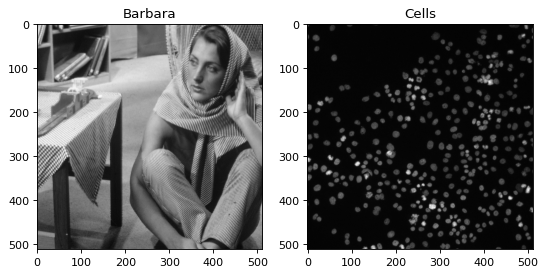

In [3]:
# load the images
x1 = np.float64(plt.imread('barbara.png'))
x2 = np.float64(plt.imread('cells.png'))

# rescale the images in the range 0-255
x1 = scale(x1)
x2 = scale(x2)

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Barbara')
plt.subplot(122)
plt.imshow(x2, cmap='gray')
plt.title('Cells')
plt.show()

* Compute the FFT (Fast Fourier Transform) of the Barbara image.

In [4]:
x1_fft = np.fft.fft2(x1)

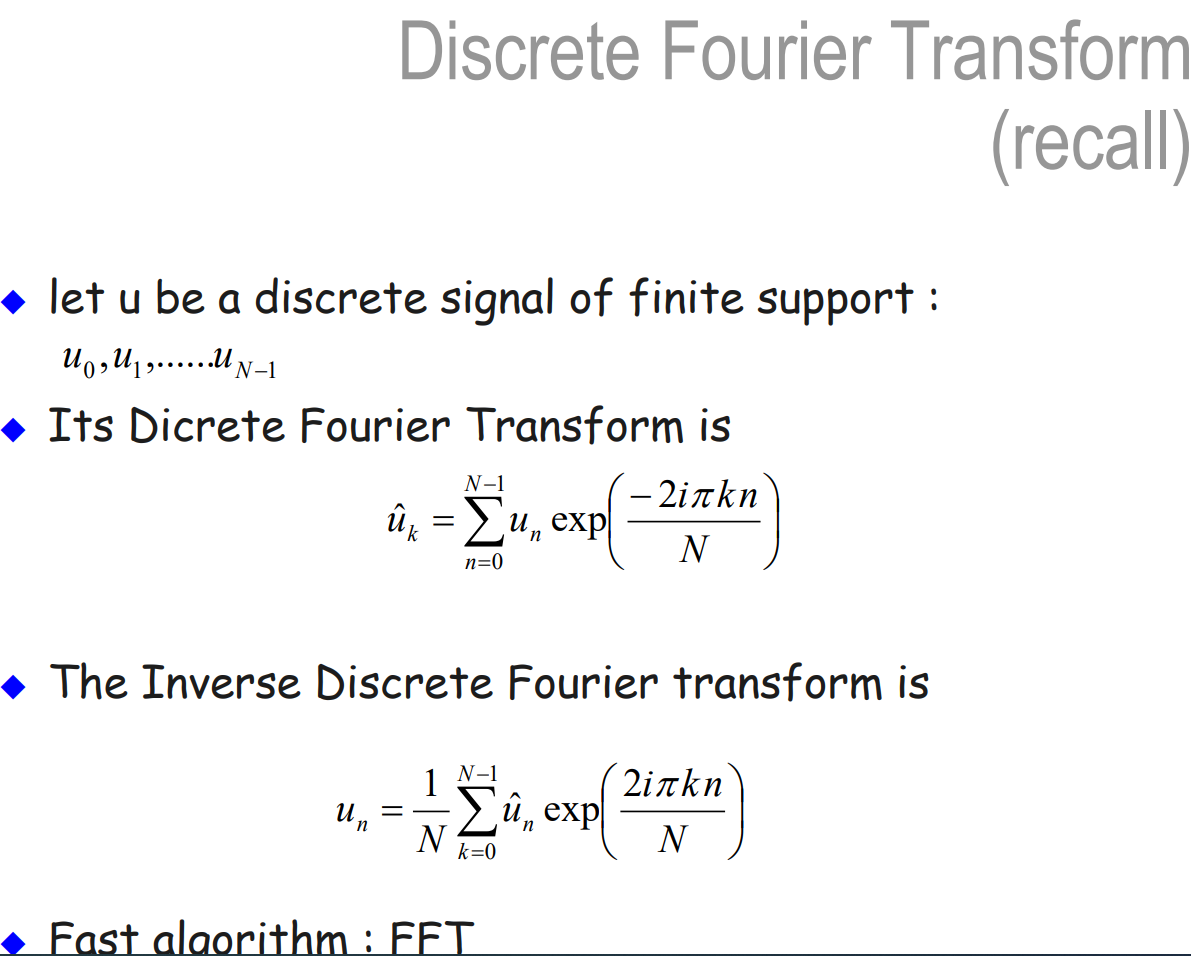

## 1.2 Noise Generation

Add noise, $\eta$, to the "Barbara" image where

$$\eta \sim \mathcal{N}(0, \sigma^2 I)$$

Plot the original and the noisy image.  

_Hint_: you can use the np.random.randn() function

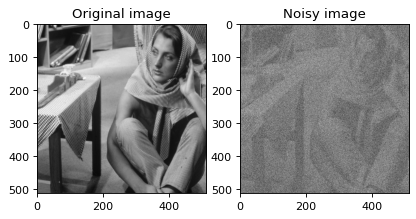

In [5]:
sig = 150                     # SD of Gaussian noise
x1_noise = x1 + sig*np.random.randn(*np.shape(x1))

plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(x1_noise, cmap='gray')
plt.title('Noisy image')
plt.show()

Like we can see in the right image, we can observe the noise in the image!

* Compute the SNR between "Barbara" and its noisy version. 

In [6]:
print(f'SNR between barbara and the noisy version = {np.round(snr(x1, x1_noise), 2)} dB')

SNR between barbara and the noisy version = -1.3 dB


To quantify the strength of the original image $x_o$ in comparison to its noisy counterpart $x_n$, we use the Signal-to-Noise Ratio (SNR) measure, defined as:

$$ \text{SNR}(x_o,x_n) = 20\log_{10} {\frac{ \|x_o\| }{ \|x_o-x_n\| } } $$ 

It is a quantity expressed in decibels (dB). The higher the SNR, the better the signal quality. The SNR how we can see in the result is very low, so we don't have a good signal.

## 1.3 Image Blurring

We consider an image model where the observed image $y$ is a result of a degradation of an image $x$ by a linear transformation $f$, i.e.

$$
mat(y)=f(mat(x))
$$

where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

Here $x$ and $y$ are images of size $512 \times 512$, then  $x\in \mathbb{R}^{512\times512}$ and  $y\in \mathbb{R}^{512\times512}$.

A common degradation is the blurring, achieved by convolving the image $x$ with a low-pass Gaussian filter kernel $h$. The blurred image $y$ is given by:

$$
mat(y)=mat(h)*mat(x) 
$$.

A common notation  is the matrix/vector notation:

$$
y= A x
$$

where $A$  is the matrix that does the convolution of the image $x$ by the Gaussian filter $h$. Here, $y$ and $x$ is the vectorized form of the images $mat(y)$ and $mat(x)$ respectiverly, in the lexical order. Then, $y\in \mathbb{R}^{N\times 1}$ and $x\in \mathbb{R}^{N\times 1}$ where $N$ is the number of pixels. It is important, as we will observe in the lab, that even though we use the notation for $A$, we do not actually construct the matrix. 

As you just observed, it is not always wise to create the full matrix $A$. So we will start by creating the function $f(mat(x))=mat(h)*mat(x)$, where $*$ denotes the convolution. Since convolution in time corresponds to multiplication in the frequency domain, we will do the convolution in the Fourier domain.

Compute the low pass Gaussian kernel with $\sigma=5$ pixels.  

The steps to create the convolution kernel is: 
1. Create a meshgrid of same size of the image (512x512). The center of the meshgrid could be 0. 
2. Apply the the Gaussian function onto the grid, and normalize the response such that the sum of all elements in the reponse =1. 
3. Apply the Fast Fourier Transformation. NOTE: If the center of the grid was defined as 0, a fftshift has to be done before applying the FFT2. 

In [7]:
sigma = 5
n = x1.shape[0]
t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )

Y, X = np.meshgrid(t, t)
h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
h = h / np.sum(h)
hf = np.real(np.fft.fft2(h))

Plot the convolution kernel before and after the fourier transform in the Fourier domain.  

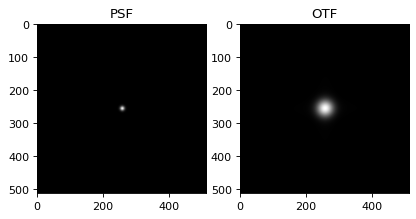

In [8]:
plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.subplot(122)
plt.imshow(np.fft.fftshift(hf), cmap='gray')
plt.title('OTF')
plt.show()

Compute the blurred image using periodic convolution with FFTs.

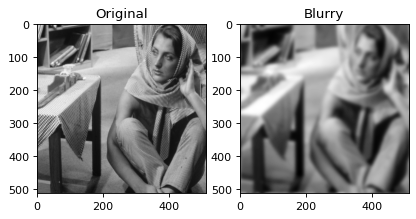

In [9]:
y1_bl = np.real(np.fft.ifft2(hf * np.fft.fft2(x1)))

plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(y1_bl, cmap='gray')
plt.title('Blurry')
plt.show()

# 2. Introduction to Inverse Problems

A more realistic model writes
$$
mat(y)=f(mat(x)) + mat(\eta) \qquad (1)
$$
where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

A more common notation to write (1) is: 
$$
y= Ax + \eta
$$
where $A$ is the linear transformation and $x$, $y$ and $\eta$ are viewed as vectors. However, when working in image processing the matrix $A$ will rearly be constructed, and we will not reshape the image $x$ as a vector.  It is important, as we have observed in the lab, that even though we use the notations $A$, we do not actually construct the matrix. 

In this lab, we considerer that the noise, $\eta$ follows a multidimensional normal law of covarience $\sigma^2 I$ and of mean the zero vector. So, we can write: $\eta \sim \mathcal{N}(0, \sigma^2 I)$. 
  
The probability density function $p(\eta)$ is written as: 
\begin{equation}
 p(\eta) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \exp \left(-\frac{\|\eta\|_2^2}{2\sigma^2}\right)
\end{equation}
 where $N$ is the number of pixels and $\|\eta\|_p$ is the $l^p$-norm defined as: 
\begin{equation}
  \|\eta\|_p = \left(\sum_{i=1}^N |\eta|^p\right)^{\frac{1}{p}}
\end{equation}
 
 We want to find the unknown image $x$ from the observation $y$. Therefore, we use the  maximum likelihood estimation which maximizes the likelihood $L(y,x)$ with respect to the unknown image $x$. This likelihood is equal to the conditional probability of $y$ knowing $x$, denoted $p_{y|x}(y|x)$. The probability is calculated from the image model, supposing that the $\eta$ is white Gaussian noise. 

More precisely, the likelihood $L(y,x)$ is given by:
\begin{equation}
 L(y,x) = p_{y|x}(y|x) = p_n(n=Ax - y) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \textrm{exp}\left(-\frac{\|Ax-y\|_2^2}{2\sigma^2}\right)
\end{equation}

We search for an estimation $\hat{x}$ of the real image $x$ by maximizing the ligelihood  $L(y,x)$ as follows: 
\begin{equation}
 \hat{x} = \arg\max_x L(y,x)
\end{equation}

In order to avoid the difficulties related to the exponential, we often maximize the logarithm of the likelihood (which does not change the maximum argument since the logarithm is strictly increasing):
\begin{equation}
 \hat{x} = \arg\max_x \, \ln(L(y,x)) = \arg\max_x \, \left(- \ln \left(2\pi\sigma^2 \right)^{\frac{N}{2}} -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The term $- \ln \left( 2\pi\sigma^2 \right)^{\frac{N}{2}}$ is a constant with respect to $x$, and thus does not intervene in the estimation of $\arg\max$. Therefore, we can write:
\begin{equation}
 \hat{x} = \arg\max_x \, \left( -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The last step removes the proptionality coefficent $\frac{1}{2\sigma^2}$ and the negative sign by using the fact that  $\arg\max_x -f(x) = \arg\min_x f(x)$. So, finally: 

\begin{equation*}
 \hat{x} = \arg\min_x \, \|Ax-y\|_2^2 
\end{equation*}


Denote $J(x)=\|Ax-y\|_2^2 $. This term is in fact the Least Square term associated to the system $y = Ax$. The gradient of $J$ is $\nabla J(x)= 2A^*(Ax-y)$, where $A^*$ is the adjoint operator of A.

In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. The algorithm can be written as:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

## 2.1 Deconvolution Example

Let $y$ be a blured image (without adding any noise). Compute the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT.

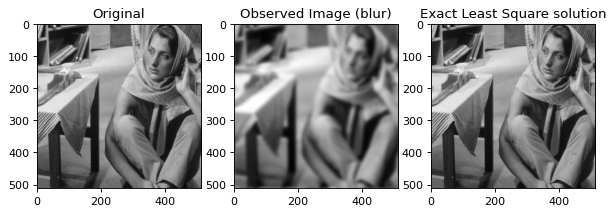

In [10]:
# -- Exact Least Square solution using Fourier
hf_adj = hf.conj()  # H*, H*x  is calculated by ifft2(Hetoile.*fft2(x));
x1_sol_ex = np.real(np.fft.ifft2(hf_adj*np.fft.fft2(y1_bl)/(abs(hf)**2)))

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot y
plt.subplot(132)
plt.imshow(y1_bl, cmap='gray')
plt.title('Observed Image (blur)')
# plot xsol
plt.subplot(133)
plt.imshow(x1_sol_ex, cmap= 'gray')
plt.title('Exact Least Square solution')
plt.show()

Add white Gaussian noise ($\sigma=10$) to the blurred image $y$ of the previous question. Compute again the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT. What do you observe?

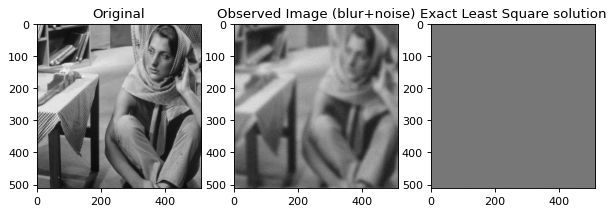

In [11]:
sig = 10                     # SD of Gaussien noise
y1 = y1_bl + sig*np.random.randn(*np.shape(x1))

hf_adj = hf.conj()  # H*, H*x  is calculated by ifft2(Hetoile.*fft2(x));
x1_sol_ag = np.real(np.fft.ifft2(hf_adj*np.fft.fft2(y1)/(abs(hf)**2)))

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot y
plt.subplot(132)
plt.imshow(y1, cmap='gray')
plt.title('Observed Image (blur+noise)')
# plot xsol
plt.subplot(133)
plt.imshow(x1_sol_ag, cmap='gray')
plt.title('Exact Least Square solution')
plt.show()

• Inverse g = h * u + n is an ill posed problem

- when we include blurring and noise it often leads to ill-posed problem like we see in this example.

An ill-posed problem is a type of mathematical problem that does not have a unique solution or has solutions that are highly sensitive to small changes in the input data or parameters. In other words, the problem lacks sufficient information or constraints to guarantee a well-defined and stable solution.

#### Gradient Descent algorithm
In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. Recall that it is an iterative algorithm, where each update is given by:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

Complete the gradient descent function below, plot the cost/error function along with the resulting image. Ensure that the cost function consistently decreases (debug your code if necessary!). What observations can you make for different values of K?

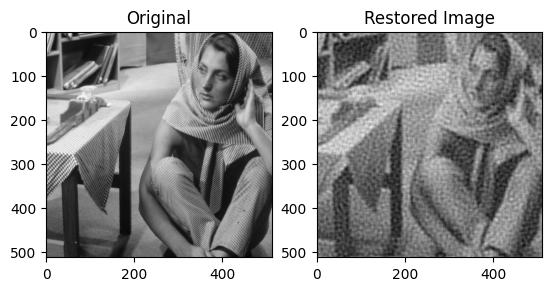

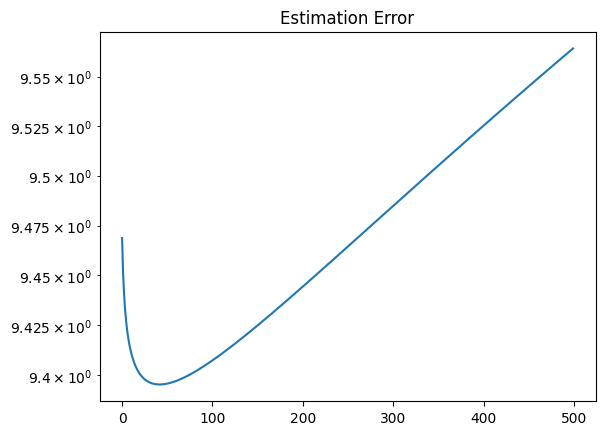

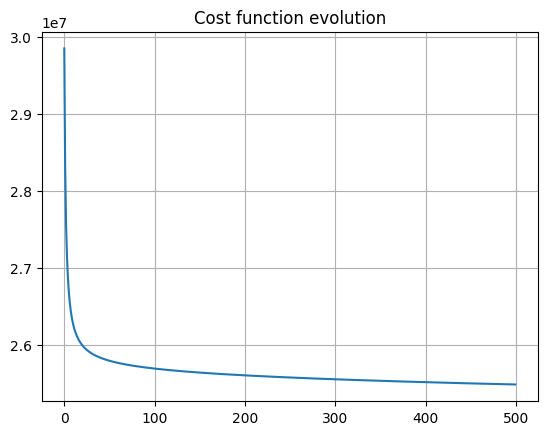

In [12]:
# -- Gradient Descent algo

#-- Parameters
alpha = 0.4                   # Step
K = 500                       # Number of iterations

# Initialisation
xk = y1
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
    #  gradient
    gradJ = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk))-y1)))
    # update xk
    xk = xk - alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk)) - y1))**2  #  Cost function
    err[k] = np.linalg.norm(xk-x1)  # error between xk and the original image
    k += 1


# -- plots
# plot x
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot xk
plt.subplot(122)
plt.imshow(xk, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Write your answer here

######  As K increases, the restored image tends to improve in quality in general, but I see that is not my case, I observe a deteriored image.
Higher values of K allow more iterations of the gradient descent algorithm, which can lead to finer adjustments and better convergence towards a high-quality restoration.

##### Cost Function Evolution:

The cost function evolution plot shows how the cost decreases over iterations of the gradient descent algorithm.
For smaller values of K, like I can observe in the plot, the cost function decrease rapidly initially but then level off or decrease more slowly as the algorithm approaches convergence.

With larger values of K, the cost function continue to decrease steadily over more iterations, reflecting more thorough exploration of the optimization landscape.

##### Estimation Error

The behavior I observe in the estimation error, where it initially decreases and then increases, suggests that the optimization process may not have converged optimally.

At the beginning of the optimization process, the algorithm is likely making significant improvements to the restored image. This leads to a decrease in the estimation error as the restored image gets closer to the original one.

After some iterations, the optimization process might start to encounter difficulties in further improving the restoration. This could be due to factors such as reaching a local minimum or encountering noise that complicates the optimization landscape.
As a result, the algorithm may begin to introduce errors or inaccuracies, causing the estimation error to increase despite ongoing iterations.
For this reason we can observe that the second image is not clear.

### Tikhonov regularisation


We now consider the following penalised criterion $$\mathcal{J}(x):= \|Ax-y\|_2^2 + \lambda\mathcal{R}(x)$$ where $\mathcal{R}(\cdot)$ is a regularisation term. 


* Explain why this term is introduced.


**Write your answer here**

We consider these two regularisation terms in this lab: 
\begin{align*}
    \mathcal{R}_1(x) &=  \|x\|_2^2 \\
    \mathcal{R}_2(x) &=  \|\nabla x\|_2^2
\end{align*}
where $\lambda>0$ is a regularisation parameter that controls the weight of the regularisation, and $$\|\nabla x \|_2 = \sum_{i,j}((\nabla x)_{i,j})^2$$
with
\begin{align}
&(\nabla x)_{i,j} = \big( (\nabla x)_{i,j}^1,(\nabla x)_{i,j}^2 \big)\\
&(\nabla x)_{i,j}^1 = (x_{i+1,j}-x_{i,j})\quad\text{if}\quad i<N,\qquad 0 \quad\text{if}\quad i=N \\
&(\nabla x)_{i,j}^2 = (x_{i,j+1}-x_{i,j})\quad\text{if}\quad j<N,\qquad 0 \quad\text{if}\quad j=N \\
\end{align}
where $N \times N$ is the size of the image.

* Compute their gradients and then complete the following python functions.

In [13]:
def reg_1(x):
    return np.linalg.norm(x)**2

def grad_reg_1(x):
    return 2*x

def reg_2(x):
    gx, gy = np.gradient(x)
    return (gx**2 + gy**2).sum()

def grad_reg_2(x):
    return -laplace(x)

* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_1(\cdot)$.

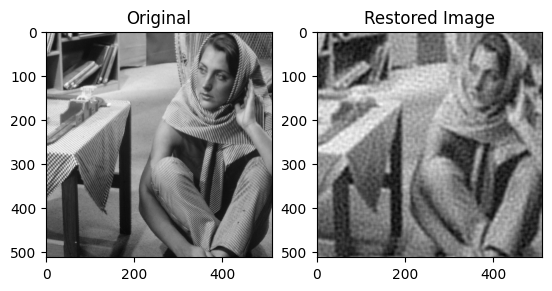

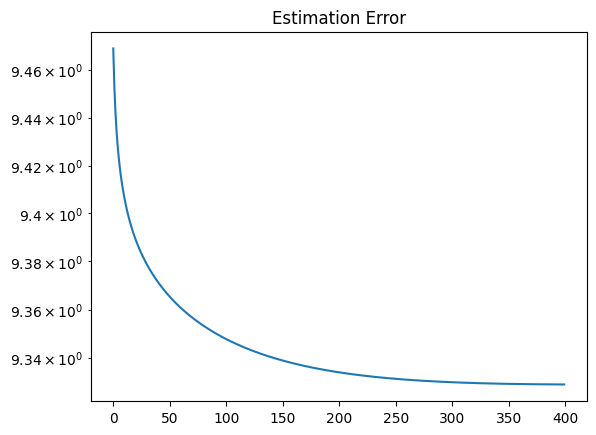

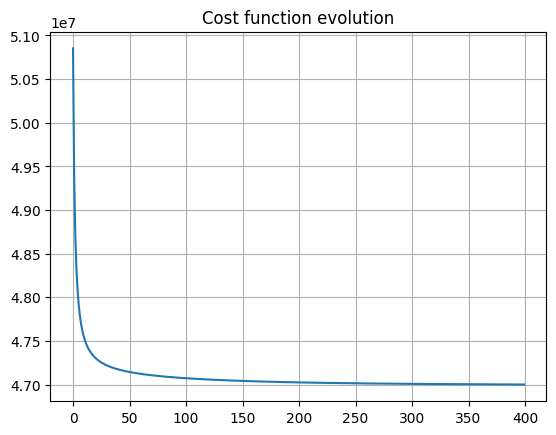

In [14]:
# -- Gradient Descent algo (R_1(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambd = 0.005

# Initialisation
xk_tn = y1  # tikhonov-nograd initialisation
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
    #  gradient
    fidelity_grad = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tn))-y1)))
    gradJ = fidelity_grad + lambd * grad_reg_1(xk_tn)
    # update xk
    xk_tn = xk_tn - alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tn))-y1))**2 + lambd*reg_1(xk_tn)  #  Cost function
    err[k] = np.linalg.norm(xk_tn-x1)  # error between xk and the original image
    k += 1


# -- plots
# plot x
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot xk
plt.subplot(122)
plt.imshow(xk_tn, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_2(\cdot)$.

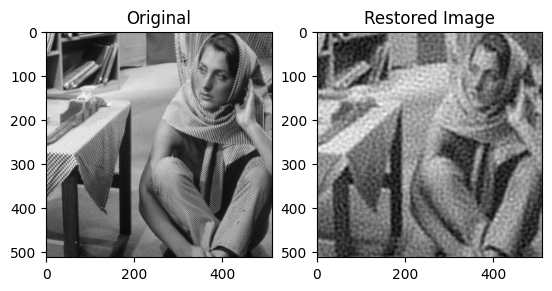

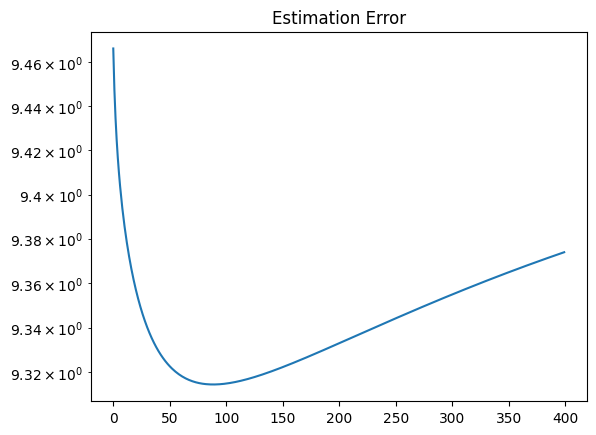

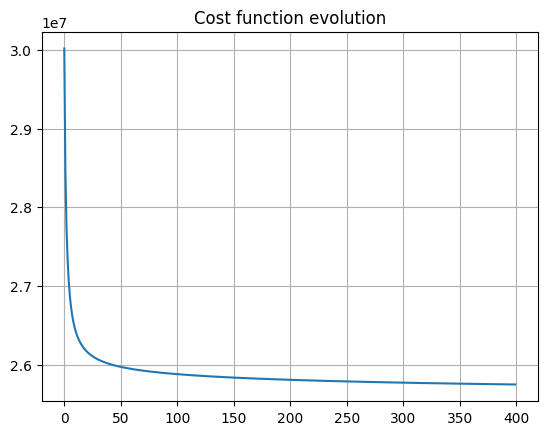

In [15]:
# -- Gradient Descent algo (R_2(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambd = 0.01

# Initialisation
xk_tg = y1
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
   #  gradient
    fidelity_grad = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1)))


    gradJ = fidelity_grad + lambd * grad_reg_2(xk_tg)
    # update xk
    xk_tg = xk_tg - alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1))**2 + lambd*reg_2(xk_tn) #  Cost function
    err[k] = np.linalg.norm(xk_tg-x1)  # error between xk and the original image
    k += 1


# -- plots
# plot x
plt.subplot(121)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot xk
plt.subplot(122)
plt.imshow(xk_tg, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Modify $\lambda$ to observe the influence. 

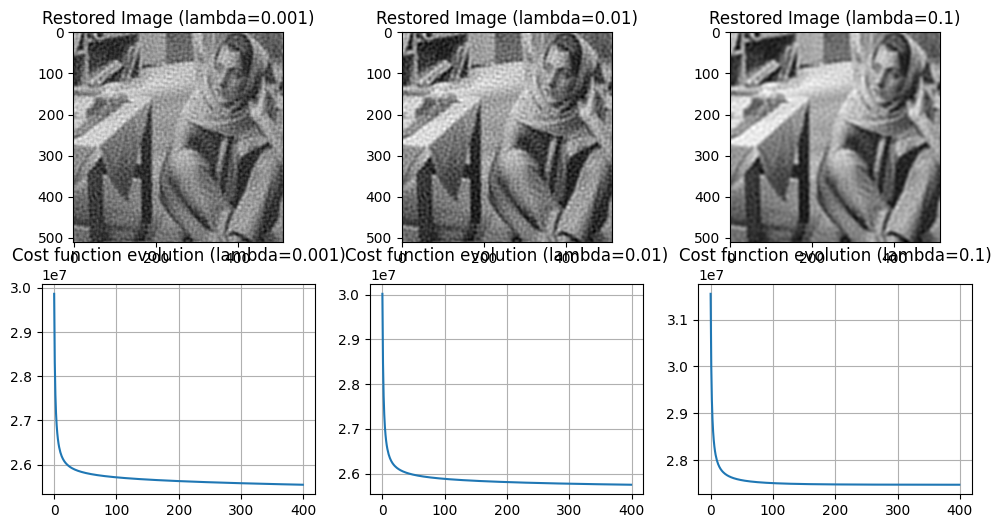

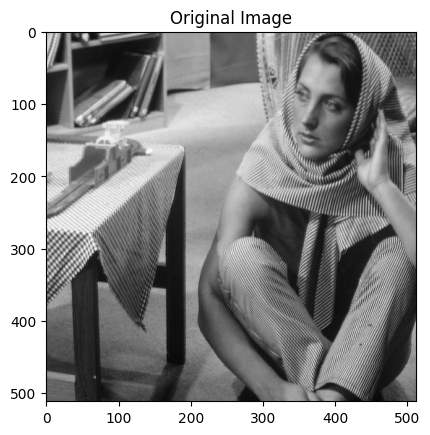

In [16]:
def gradient_descent(alpha, K, lambd):
    # Initialization
    xk_tg = y1
    J = np.zeros(shape=(K))    # Cost
    err = np.zeros(shape=(K))  # Error

    # Main loop
    k = 0
    while k < K:
        # Gradient
        fidelity_grad = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1)))
        gradJ = fidelity_grad + lambd * grad_reg_2(xk_tg)
        
        # Update xk
        xk_tg = xk_tg - alpha * gradJ
        
        # Calculate cost and error
        J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1))**2 + lambd * reg_2(xk_tn)
        err[k] = np.linalg.norm(xk_tg - x1)
        
        k += 1

    return J, err, xk_tg

# Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambdas = [0.001, 0.01, 0.1]  # Different values of lambda to observe its influence

# Plotting
plt.figure(figsize=(12, 6))

for i, lambd in enumerate(lambdas):
    # Run gradient descent
    J, err, xk_tg = gradient_descent(alpha, K, lambd)
    
    # Plot the restored image
    plt.subplot(2, len(lambdas), i + 1)
    plt.imshow(xk_tg, cmap='gray')
    plt.title(f'Restored Image (lambda={lambd})')

    # Plot the cost function evolution
    plt.subplot(2, len(lambdas), len(lambdas) + i + 1)
    plt.plot(J)
    plt.title(f'Cost function evolution (lambda={lambd})')
    plt.grid(True)

# Plotting the original image
plt.figure()
plt.imshow(x1, cmap='gray')
plt.title('Original Image')

plt.show()

* Observe the restored images, and compare them to the true image by computing the SNR. 

In [17]:
print('SNR (Noisy)',"{:.2f}".format(snr(x1, y1)), 'dB')
print('SNR (NoReg):',"{:.2f}".format(snr(x1, xk)), 'dB')
print('SNR (Tikhonov, Nograd):',"{:.2f}".format(snr(x1, xk_tn)), 'dB')
print('SNR (Tikhonov, Grad):',"{:.2f}".format(snr(x1, xk_tg)), 'dB')

SNR (Noisy) 13.90 dB
SNR (NoReg): 13.35 dB
SNR (Tikhonov, Nograd): 15.39 dB
SNR (Tikhonov, Grad): 15.79 dB
